In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch
from numpy.linalg import norm

## TO DO
1. Check Newton's method
2. Write simulation comparison code / Post Processing (in-progress; BP)
3. Apply to real dataset

## FINISHED
1. Write data generating function
2. Write Normal Equation function (theoretical)
3. Define SGD function
4. Define Quasi-Newton's function
5. Define Newton's method
6. Write simulation function

## Functions

In [2]:
# The func below should prob be used over the create_sim_data_lr above

def sim_lm(n_obs, m_betas, X=None, b=None, seed=None):
    """Simulate a linear model as Xb = y.
    
    Parameters
    ----------
    n_obs : int
        Number of observatins (rows of X).
    m_beta : int
        Numbers of beta weights.
    X : 2d array, optional, default: None
        Features. Defaults to random normal.
    b : 1d array, optional default: None
        Beta weights. Default to random normal.
    seed : int, optional, default: None
        Random seed for reproducibility.
        
    Returns
    -------
    X : 2d tensor
        Features.
    b : 1d tensor
        Beta weights.
    y : 1d tensor
        Target.
    """
    
    # Set seed
    if seed is not None:
        np.random.seed(seed)
           
    # Initalize arrays
    if X is None:
        X = np.random.normal(size=(n_obs, m_betas))
        
    if b is None:
        b = np.random.normal(size=m_betas)

    # Solve y that corresponds to b and X
    y = np.dot(X, b).reshape(-1, 1)
    
    # Torch's linear layers require f32 tensors
    X = X.astype(np.float32)
    b = b.astype(np.float32)
    y = y.astype(np.float32)

    # Create tensors
    X = torch.from_numpy(X)
    b = torch.from_numpy(b)
    y = torch.from_numpy(y)
    
    return X, b, y

### Newton's Method Implementation Derivation

Method somewhat adapted from https://thatdatatho.com/newtons-method-bfgs-linear-regression/\

Our contributions:
1. Detailed derivation of implementation
2. Our implementation is written in python

Each step of the Newton's method is:
$$\beta^{k+1} = \beta^{k} - H(\beta^{k})^{-1} \triangledown f(\beta^{k})$$

Start with linear regression general form:
$$y = X \beta + \epsilon$$

For least squares, the error $\epsilon^{'}\epsilon$ must be minimized to create a best fit line. This is:
$$f(\beta^{k}) = \epsilon^{'}\epsilon = (y- X\beta)^{'} (y- X\beta)$$

Distributing the terms, it becomes:
$$f(\beta^{k}) = \epsilon^{'}\epsilon = y^{'}y - y^{'}X\beta -\beta^{'}X^{'}y + \beta^{'}X^{'}X \beta$$

$f(\beta^{k}) = \epsilon^{'}\epsilon$ can be further simplified:

$$ \beta^{'}X^{'}y = (\beta^{'}X^{'}y)^{'} = y^{'}X \beta$$
This is because:
$$LHS: 1 \times m * m \times n * n \times 1 = 1 \times m * m \times 1 = 1 \times 1$$

$$RHS: 1 \times n * n \times m * m \times 1 = 1 \times n * n \times 1 = 1 \times 1$$

This is even tested below:

In [3]:
diffs = []
for k in range(100):
    X,b,y = sim_lm(100,10,seed = k)
    lhs = np.matmul(b.T,np.matmul(X.T,y))
    rhs = np.matmul(y.T,np.matmul(X,b))
    #assert(lhs == rhs) # This actually fails...
    diff = lhs - rhs
    diffs.append(diff.item())

np.mean(diffs) #3.96728515625e-06


/tmp/ipykernel_93/59248963.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  lhs = np.matmul(b.T,np.matmul(X.T,y))


7.9345703125e-06

Across 100 different simulations, it can be seen that the difference between the LHS and the RHS is extremely small. Therefore:
$$LHS \approx RHS$$
$$\beta^{'}X^{'}y \approx y^{'}X \beta$$

Using this approximation, the least-squares equation becomes:

$$f(\beta^{k}) = \epsilon^{'}\epsilon = y^{'}y -2\beta^{'}X^{'}y + \beta^{'}X^{'}X \beta$$

To compute the gradient, the derivative of this function must be taken wrt $\beta$. The derivative of each term wrt $\beta$ is taken.

$$\frac{\partial y^{'}y}{\partial \beta} = 0$$

$$\frac{\partial (-2\beta^{'}X^{'}y)}{\partial \beta} = -2X^{'}y$$

$$\frac{\partial \beta^{'}X^{'}X \beta}{\partial \beta} = 2 X^{'}X \beta$$


This comes from the identity (A.8.2, Linear Regression Analysis Second Edition, Seber):
$$\frac{\partial B^{'}A B}{\partial B} = 2A B$$
Where:

$$A = X^{'}X$$
$A$ must be symmetric. $X^{'}X$ is symmetric because $(X^{'}X)^{'} = (X^{'}X)$
$$B = \beta$$

Proof:
$$\frac{\partial B^{'}A B}{\partial B_{i}} = = \frac{\partial}{\partial B_{i}} (\Sigma_{i}\Sigma_{j} a_{ij} B_{i} B_{j})$$
$$2a_{ij}B_{i} + 2 \Sigma_{j \neq 1} a_{ij} B_{j}$$
$$2\Sigma_{j} a_{ij}B_{j}$$
$$2(A B)_{i}$$

Plugging the simplification in and taking the derivative wrt $\beta$:

$$\triangledown f(\beta^{k}) = \frac{\partial \epsilon^{'}\epsilon}{\partial \beta} = -2X^{'}y + 2X^{'}X \beta = 0$$

$$\triangledown f(\beta^{k}) = \frac{\partial \epsilon^{'}\epsilon}{\partial \beta} = -X^{'}y + X^{'}X \beta = 0$$

$$\triangledown f(\beta^{k}) = \frac{\partial \epsilon^{'}\epsilon}{\partial \beta} = -X^{'} (y - X \beta) = 0$$

The Hessian is easily found by taking the derivative of the gradient wrt to beta:
$$H(\beta^{k}) = \frac{\partial^{2} \epsilon^{'}\epsilon}{\partial \beta^{2}} = X^{'}X = 0$$

In [4]:
### Normal Equation (Theoretical)
# Closed Form Solution
# beta_hat = (X^T %*% X)^-1 %*% X %*% y
def normal_eq_lr(X,y):
    A = np.linalg.inv(np.matmul(np.transpose(X),X))
    B = np.matmul(np.transpose(X),y)
    return(np.matmul(A,B))


### Newton's method
### Adapted partially from https://thatdatatho.com/newtons-method-bfgs-linear-regression/

def Newton(X,y,max_iter = 250):
    """Simulate a linear model as Xb = y.
    
    Parameters
    ----------
    X : 2d array, default: None
    Features.
    y : 1d array, default: None
    Observations.
    error: float, optional, default: 10**-5
    Stopping threshold for gradient norm. Defaults to 10**-5
    max_iter: int, optional, default: 250
    Maximum iterations for Newton's method. If solution has not been found, alg stops.
        
    Returns
    -------
    (betas,MSEs)
    betas : m x 1 tensor
        Solution for least squares.
    MSEs_to_npy : numpy array
        MSE of each y_hat from the beta solution for each iteration. If there is no convergence on the kth step
        The MSE of the kth step and any other step until the max_iterth step is nan.
    """
    # Convert from tensor to numpy array
    X = np.array(X)
    
    m = X.shape[1]
    n = y.shape[0]
    
    
    beta = np.zeros((m,1)) # Start with a guess
    A = -np.transpose(X)
    B = y - np.matmul(X,beta)
    gradient = np.matmul(A,B) # 2 * t(X) %*% X %*% beta
    hessian = np.matmul(np.transpose(X),X) # 2 * t(X) %*% X
    
    # Start Newton's method implementation here:
    k = 0
    grads = dict()
    MSEs = dict()
    while k < max_iter: # stop if exceeds max iterations allowed
        A = -np.transpose(X)
        B = y - np.matmul(X,beta)
        gradient = np.matmul(A,B)
        try:
            grads[k] = norm(gradient) # If norm of gradient cannot be calculated because there's an infinite in there
            # There is no convergence.
            hessian = np.matmul(np.transpose(X),X)
            search = np.matmul(np.linalg.inv(-hessian),gradient).numpy()
            beta = beta + search # beta - inv(-hessian) %*% gradient
            y_hat = torch.tensor(np.matmul(X,beta)) # calculate y_hat from beta solution for each iteration tf.convert_to_tensor(numpy_array)
            loss_func = torch.nn.MSELoss()
            MSEs[k] = loss_func(y_hat, y)
            k += 1
        except:
            while k < max_iter:
                MSEs[k] = np.nan # Since it breaks on this kth step, make this MSE NA
                k += 1 # Also do this for any step after this step.
            MSEs_to_npy = np.array([z[1] for z in MSEs.items()])
            res = (torch.from_numpy(np.full((m,1),np.nan)),MSEs_to_npy) # Return no solution and MSEs
            # Not sure if this function should just return the beta solution in a previous epoch that worked...
            return(res)
            break
    MSEs_to_npy = np.array([z[1] for z in MSEs.items()])
    res = (torch.from_numpy(beta),MSEs_to_npy)
    return(res)

In [5]:
from torch.autograd.functional import jacobian, hessian

def newton_v2(X, y, betas_init=None, n_epochs=20):
    
    # Initalize model
    model = LinearRegression(m)

    # Required for using torch to compute gradient and hessian
    def compute_loss(betas):
        y_hat = torch.matmul(X, betas)
        return torch.nn.MSELoss()(y_hat, y)

    # Initalize random betas
    betas = torch.rand(m, 1) if betas_init is None else betas_init

    # Newton's Method
    loss = np.zeros(n_epochs)

    for n in tqdm(range(n_epochs)):

        # Compute gradient and Hessian
        grad = jacobian(compute_loss, betas)
        hess = hessian(compute_loss, betas).squeeze().inverse()

        # Step
        betas = betas - torch.matmul(hess, grad)

        loss[n] = compute_loss(betas)

    return betas, loss

In [ ]:
# ORIGINAL IMPLEMENTATION WITH EARLY STOPPING
"""
def Newton_early_stop(X,y,error = 10**-5,max_iter = 250,tol = 10**-5):
    #Simulate a linear model as Xb = y.
    
    #Parameters
    #----------
    #X : 2d array, default: None
    #Features.
    #y : 1d array, default: None
    #Observations.
    #error: float, optional, default: 10**-5
    #Stopping threshold for gradient norm. Defaults to 10**-5
    #max_iter: int, optional, default: 250
    #Maximum iterations for Newton's method. If solution has not been found, alg stops.
    #tol: float, optional, default: 10**-5
    #Tolerence of difference betas between steps. This is the early stopping criteria. 
    #If the betas are not that different, alg stops.
    #    
    #Returns
    #-------
    #(betas,iter_to_converge)
    #betas : m x 1 tensor
    #    Solution for least squares.
    #iter_to_converge : int
    #    number of iterations to converge. Could also be nan if did not converge to a solution.
    
    # Convert from tensor to numpy array
    X = np.array(X)
    y = np.array(y)
    
    m = X.shape[1]
    n = y.shape[0]
    
    
    beta = np.zeros((m,1)) # Start with a guess
    A = -np.transpose(X)
    B = y - np.matmul(X,beta)
    gradient = np.matmul(A,B)
    hessian = np.matmul(np.transpose(X),X)
    
    # Start Newton's method implementation here:
    k = 0
    grads = dict()
    betas = dict()
    while norm(gradient) > error: # stop if the norm_gradient < error
        if k > max_iter: # stop if iteration number exceeds max iteration limit
            break
        else:
            A = -np.transpose(X)
            B = y - np.matmul(X,beta)
            gradient = np.matmul(A,B)
            try:
                grads[k] = norm(gradient)
                # If norm of gradient cannot be calculated because there's an infinite in there
                # There is no convergence. Return no solution
            except:
                res = (torch.from_numpy(np.full((m,1),np.nan)),np.nan)
                return(res)
                break
            hessian = np.matmul(np.transpose(X),X) 
            search = np.matmul(np.linalg.inv(-hessian),gradient)
            beta = beta + search
            betas[k] = beta
            if k >= 1:
                diff = abs(norm(betas[k]) - norm(betas[k-1])) # stop if minimal improvement on the previous step
                if diff < tol:
                    break
            k += 1
    iter_to_converge = k
    res = (torch.from_numpy(beta),iter_to_converge)
    return(res)
"""

In [6]:
# MODELS / TRAINING
class LinearRegression(torch.nn.Module):
    """Muliple linear regression as a perceptron.
    
    Parameters
    ----------
    m_beta : int
        Numbers of beta weights.
    """
    def __init__(self, m_betas):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(m_betas, 1)
        
    def forward(self, x):
        return self.linear(x)


def train_model(X, y, method='SGD', lr=0.01, n_epochs=1000, opt_kwargs=None):
    """Train various gradient descent algorithms.
    
    Parameters
    ----------
    X : 2d tensor
        Features.
    y : 1d tensor
        Target.
    method : {'SGD', 'LBFGS'} # There is no newton implementation for pytorch, had to manually code this
        Model to train.
    lr : float, optional, default: 0.01
        Learning rate (step size).
    n_epochs : int, optional, default: 1000
        Number of training iterations.
    opt_kwargs : dict, optional, default: None
        Optimizers kwargs to pass through to pytorch.
        
    Returns
    -------
    model : LinearRegression
        Trained model.
    loss_hist : 1d array
        Loss per step.
    elapsed : float
        Total time to train and run n_epochs.
    """
    
    # Initalize model and loss function
    model = LinearRegression(len(X[0]))
    loss_func = torch.nn.MSELoss()
    loss_hist = np.zeros(n_epochs)
    
    # Select optimizer
    opt_kwargs = {} if opt_kwargs is None else opt_kwargs
    if method == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, **opt_kwargs)
    elif method == 'LBFGS':
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, **opt_kwargs)

    # Closure step function needed for LBFGS
    def closure():

        # Zero gradients
        optimizer.zero_grad()

        # Get predicted y
        y_hat = model(X)

        # Compute loss
        loss = loss_func(y_hat, y)
        
        # Backpropagate and update weights
        loss.backward()
        
        #loss_hist[i] = loss
        
        return loss
    
    # Time
    start = time.time()
    
    # Train
    for i in range(n_epochs):
        
        if method == 'SGD':
            loss = closure()
            optimizer.step()
            loss_hist[i] = loss
        elif method == 'LBFGS':
            loss = optimizer.step(closure)
            loss_hist[i] = loss


    # Time
    end = time.time()
    elapsed = end-start
    
    return model, loss_hist, elapsed


def test_train_model():
    
    """Test 1 beta and 10 beta cases."""
    N = 100
    
    for M in [1, 10]:

        X, b, y = sim_lm(N, M)

        model, loss_hist, elapsed = train_model(X, y, method='SGD')

        assert all(
            model.linear.weight[0].detach().numpy().round(2) == b.numpy().round(2)
        )

    
test_train_model()

## Simulations

The goal of these simulations is to create cases where we have n samples (could be low or high) and m features (1-1000). In the context of an optimization problem, compare the performance between SGD, Newton's method, and Quasi-Newton for each case.

Optimization problems to try: Regression, Classification (maybe if we don't have time, we can stick to regression only)

In [403]:
# Number of simulations
n_sim = 100 
#n_sim = 1
# Number of observations
n = 1000

# Number of features
ms = [1, 10, 100,1000]
#ms = [1]
# Number of epochs
n_epochs = 250

# Track loss, beta error, and elapsed time
loss_history = {
    'sgd': np.zeros((len(ms), n_sim, n_epochs)),
    'newton': np.zeros((len(ms), n_sim, n_epochs)),
    'lbfgs': np.zeros((len(ms), n_sim, n_epochs))
}

beta_mse = {
    'normal': np.zeros((len(ms), n_sim)),
    'sgd': np.zeros((len(ms), n_sim)),
    'newton': np.zeros((len(ms), n_sim)),
    'lbfgs': np.zeros((len(ms), n_sim))
}

elapsed_time = {
    'normal': np.zeros((len(ms), n_sim)),
    'sgd': np.zeros((len(ms), n_sim)),
    'newton': np.zeros((len(ms), n_sim)),
    'lbfgs': np.zeros((len(ms), n_sim))
}

for im, m in enumerate(ms):
    
    for i in tqdm(range(n_sim)):
        
        # Generate new data
        X, b, y = sim_lm(n, m, seed=i)

        # Normal equation
        start = time.time()
        b_normal = normal_eq_lr(X, y)[:, 0]
        end = time.time()
        
        beta_mse['normal'][im, i] = float(((b_normal-b)**2).mean())
        elapsed_time['normal'][im, i] = end-start
        
        # SGD
        model_sgd, loss_hist_sgd, elapsed_sgd = \
            train_model(X, y, method='SGD', n_epochs=n_epochs)
        
        b_hat_sgd = model_sgd.linear.weight[0]

        beta_mse['sgd'][im, i] = float(((b - b_hat_sgd)**2).sum())
        elapsed_time['sgd'][im, i] = elapsed_sgd
        loss_history['sgd'][im, i] = loss_hist_sgd
        
        # LBFGS  !! this is super slow, either reduce iterations or multiprocess !!
        # Took ~30 seconds for 20 iterations
        # 1000 betas is very slow
        model_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = \
            train_model(X, y, method='LBFGS', n_epochs=n_epochs)
        
        b_hat_lbfgs = model_lbfgs.linear.weight[0]

        beta_mse['lbfgs'][im, i] = float(((b - b_hat_lbfgs)**2).sum())
        elapsed_time['lbfgs'][im, i] = elapsed_lbfgs
        loss_history['lbfgs'][im, i] = loss_hist_lbfgs
        
        # DO NEWTON'S
        start = time.time()
        res_newton = Newton(X,y,max_iter = n_epochs)
        b_newton = res_newton[0][:,0]
        loss_history['newton'][im,i] = res_newton[1]
        end = time.time()
        
        beta_mse['newton'][im, i] = float(((b_newton-b)**2).mean())
        elapsed_time['newton'][im, i] = end-start

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\3281958354.py:77: RuntimeWarning: overflow encountered in matmul
  y_hat = torch.tensor(np.matmul(X,beta)) # calculate y_hat from beta solution for each iteration tf.convert_to_tensor(numpy_array)
C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\3281958354.py:69: RuntimeWarning: overflow encountered in matmul
  B = y - np.matmul(X,beta)
C:\Users\bpham\AppData\Local\Temp\ipykernel_238932\3281958354.py:70: RuntimeWarning: invalid value encountered in matmul
  gradient = np.matmul(A,B)


In [406]:
#loss_history['lbfgs'][0].shape
#(100, 250)
#loss_history['newton'][0].shape
#(100, 250)
#loss_history['sgd'][0].shape
#(100, 250)

(100, 250)

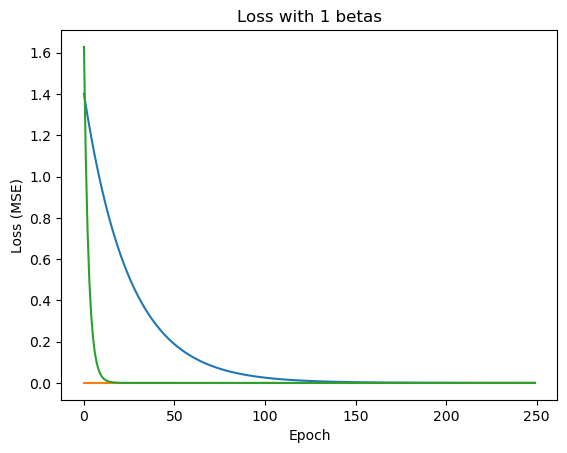

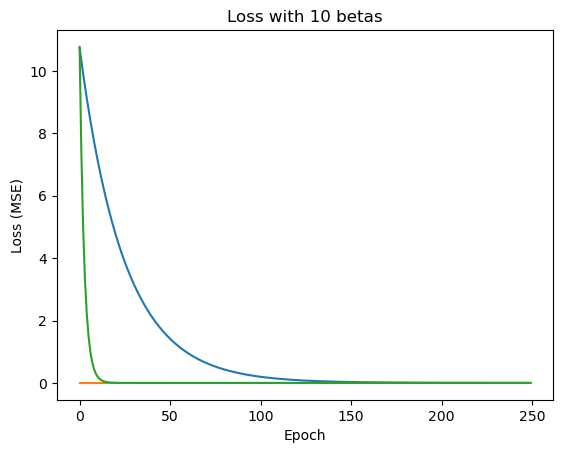

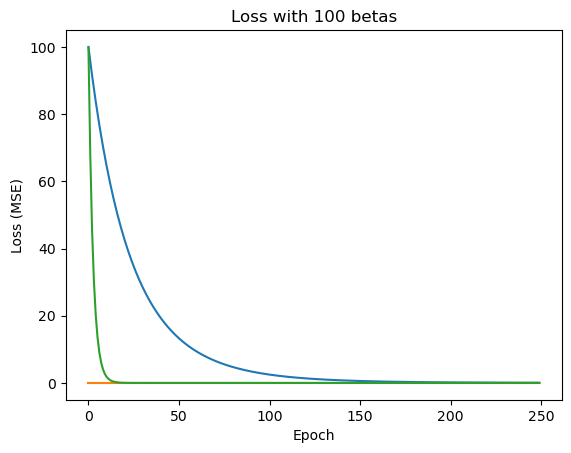

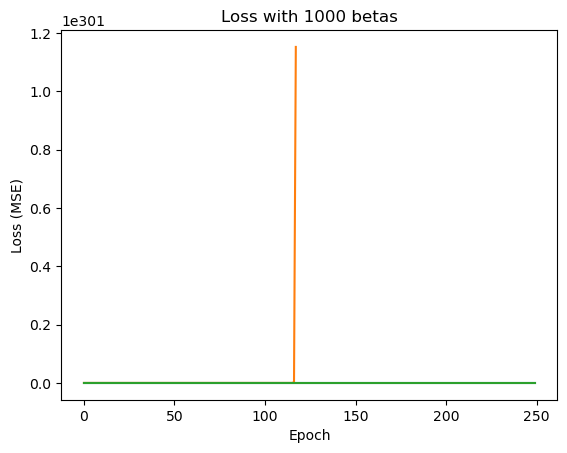

In [432]:
# Loss starts higher as betas increases, but rate of descent is similar
#   We could quantify rate of convergence as the exponential decay rate of loss

# Another thing we can do is to simply report the iteration where there is the minimum loss 
#(this should be the point of convergence)

for i in range(4):
    plt.figure(i)
    plt.title(f'Loss with {ms[i]} betas')
    plt.plot(loss_history['sgd'][i].mean(axis=0), label='SGD')
    plt.plot(loss_history['newton'][i].mean(axis=0), label='Newton')
    plt.plot(loss_history['lbfgs'][i].mean(axis=0), label='LBFGS')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')

In [435]:
pd.DataFrame(loss_history['newton'][3].mean(axis=0)) # each simulation is a row, each epoch is a column
# taking mean on axis 0 is essentially getting the average across ALL simulations per epoch

,0
0,2.730277e+02
1,1.113022e+04
2,8.533897e+05
3,8.450486e+07
4,9.596622e+09
...,...
245,NaN
246,NaN
247,NaN
248,NaN


In [418]:
np.mean(loss_history['newton'][3][0])

0.0025774138774206203

In [421]:
loss_history['newton'][3].mean(axis= 1)

array([2.57741388e-003, 2.17124855e-005, 3.10987400e-004,             inf,
       5.89921999e-004, 9.28606714e-006, 3.61667502e-005, 1.57266822e-003,
       1.16135788e-005, 5.11486388e-005, 1.12515198e-002, 7.54241636e-006,
       1.73407772e-004, 8.64623776e-003, 7.53640227e-007,             inf,
                   inf, 9.75764926e-006, 1.63733718e-003, 3.72234413e-005,
       2.14032236e-005, 1.15924077e-005, 8.97353427e-004, 4.49479102e-007,
       1.73773385e-006, 1.87932223e-003, 1.42602545e-006, 1.06105684e-005,
       3.93577384e-006, 8.26791580e-005, 7.13907160e-006, 8.74953809e-007,
       2.35491526e-004, 6.54804862e-006, 3.05389566e-005, 6.16076629e-006,
       9.01147079e+143, 5.65081503e-001, 2.61094539e-003, 3.51507858e-003,
       3.93712023e-005, 2.38893051e+022, 1.64031230e-003, 6.57080328e-004,
       9.28712597e-006, 3.87232361e-005, 9.36221264e+089, 2.11470280e+013,
       5.02730677e-006, 3.16063860e-005, 1.35947939e-004, 4.43722970e-006,
       2.17982477e-002, 1

In [351]:
loss_history['newton'][0].mean(axis=0)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

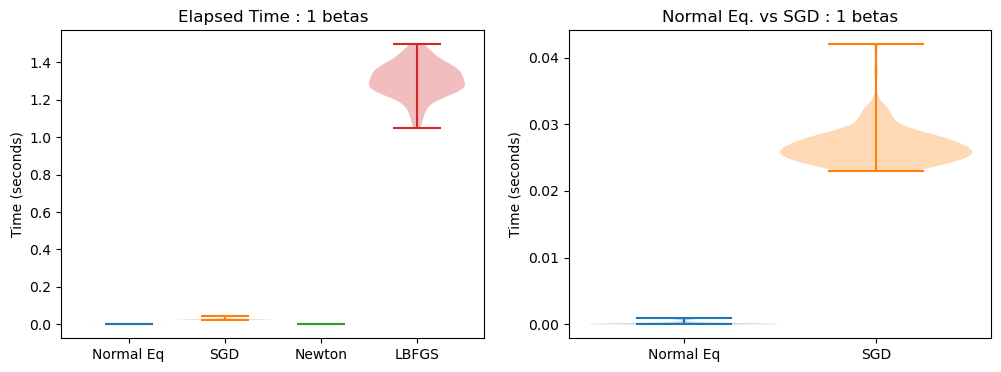

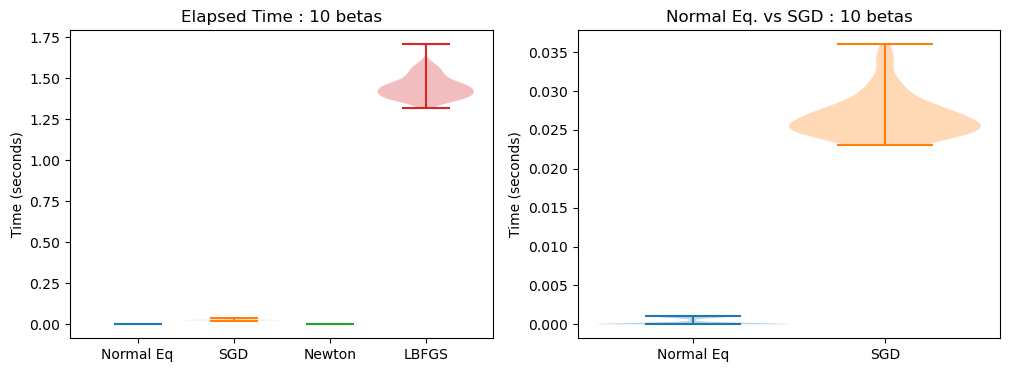

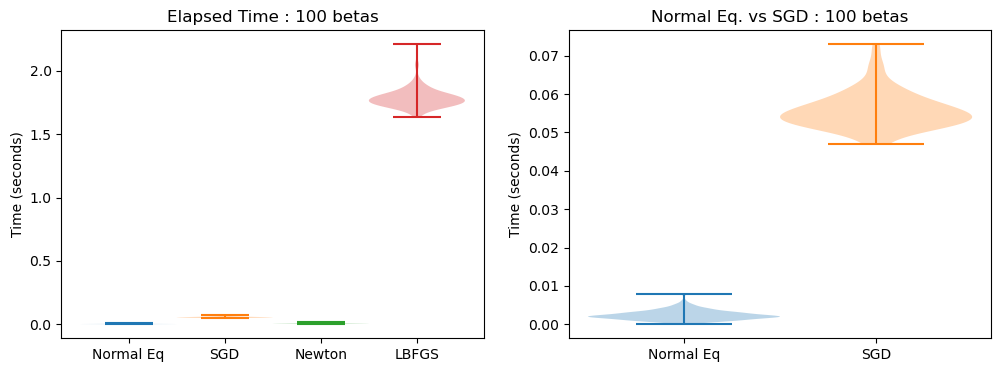

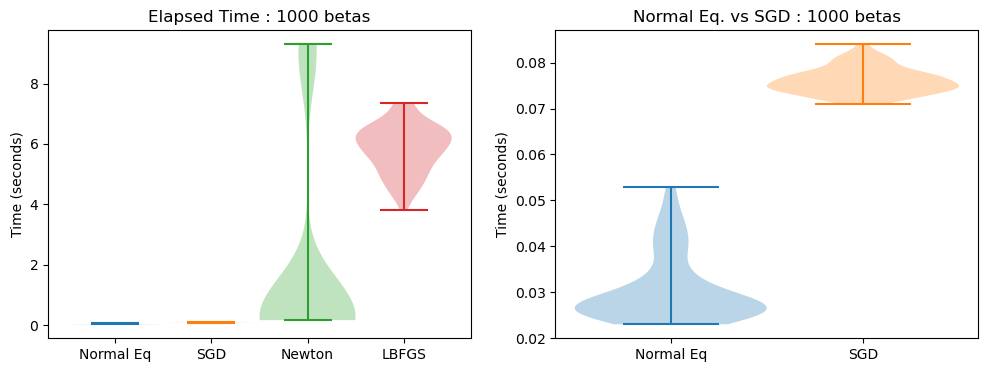

In [259]:
for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(elapsed_time['normal'][i])
    axes[0].violinplot(elapsed_time['sgd'][i], positions=[1.5])
    axes[0].violinplot(elapsed_time['newton'][i], positions=[2])
    axes[0].violinplot(elapsed_time['lbfgs'][i], positions=[2.5])
    
    axes[1].violinplot(elapsed_time['normal'][i])
    axes[1].violinplot(elapsed_time['sgd'][i], positions=[1.5])
    
    axes[0].set_xticks([1, 1.5, 2,2.5], ['Normal Eq', 'SGD','Newton', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'SGD'])
    
    axes[0].set_title(f'Elapsed Time : {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs SGD : {ms[i]} betas')
    
    axes[0].set_ylabel('Time (seconds)')
    axes[1].set_ylabel('Time (seconds)')

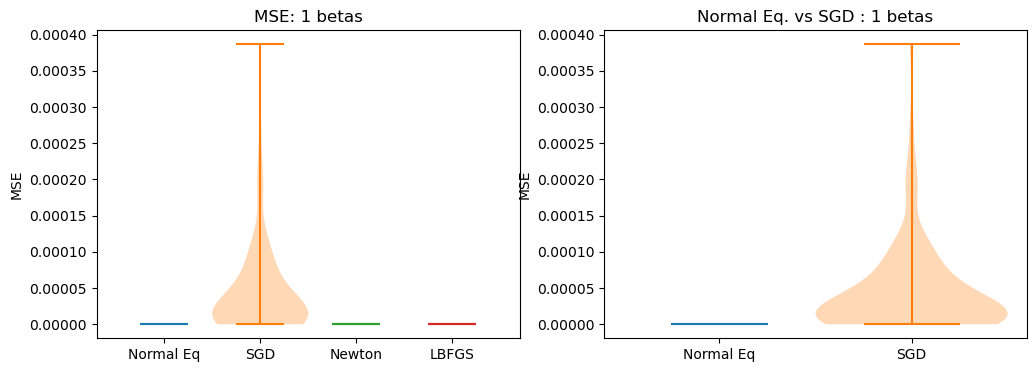

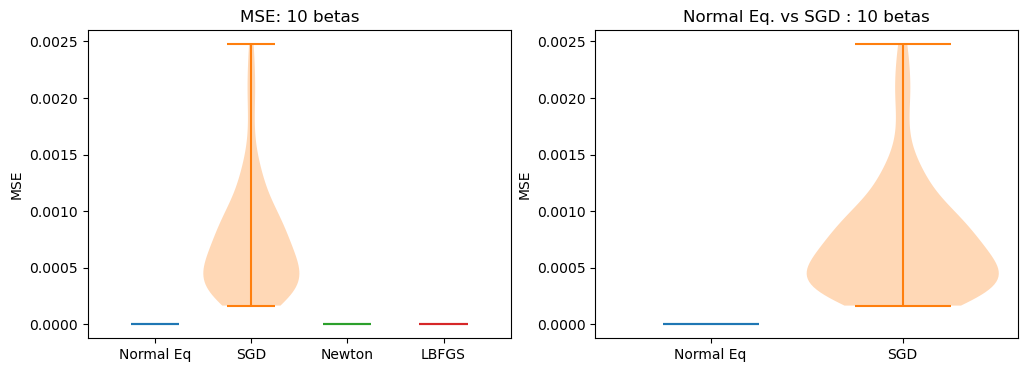

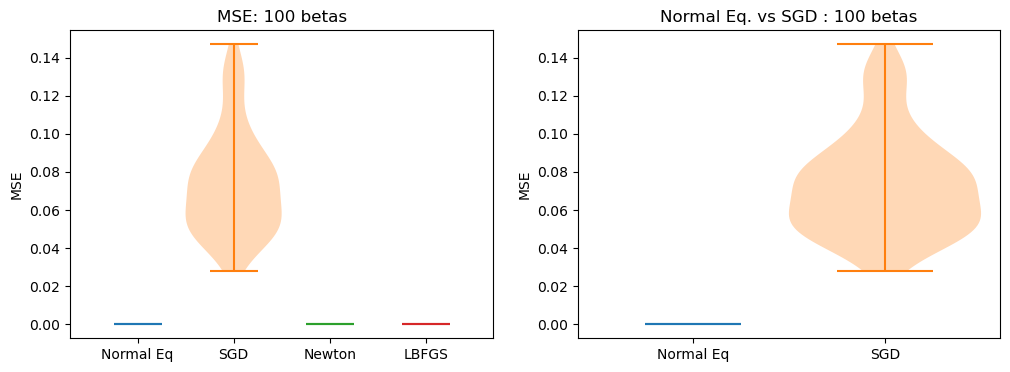

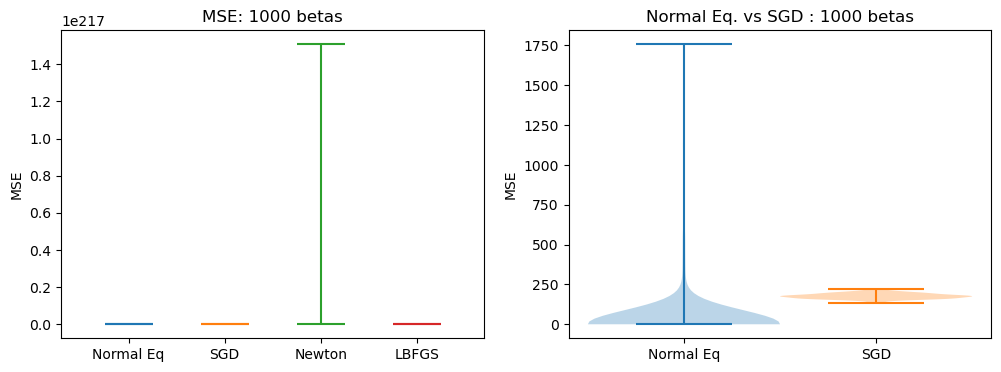

In [260]:
# Plot mse comparison
# helper function to get finite vals in the mse only
# Use this for violin plot visualizations
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])


for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[0].violinplot(get_finite_vals(beta_mse['sgd'][i]), positions=[1.5])
    axes[0].violinplot(get_finite_vals(beta_mse['newton'][i]), positions=[2])
    axes[0].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[2.5])
    
    axes[1].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[1].violinplot(get_finite_vals(beta_mse['sgd'][i]), positions=[1.5])
    
    axes[0].set_xticks([1, 1.5, 2,2.5], ['Normal Eq', 'SGD','Newton', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'SGD'])
    
    axes[0].set_title(f'MSE: {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs SGD : {ms[i]} betas')
    
    axes[0].set_ylabel('MSE')
    axes[1].set_ylabel('MSE')


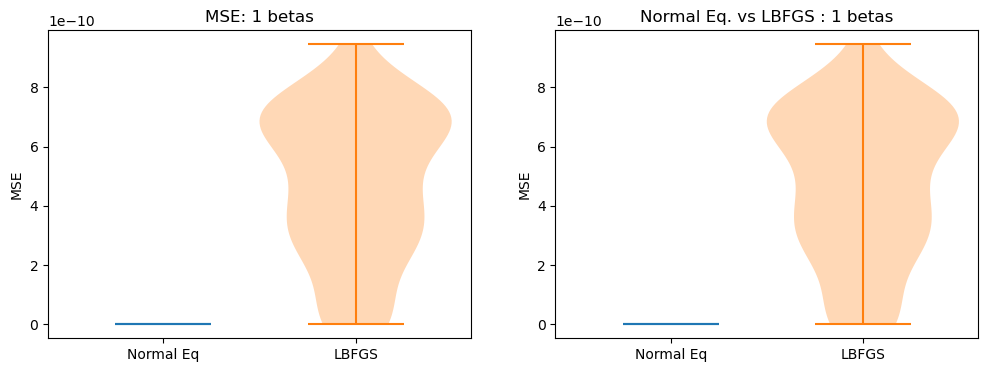

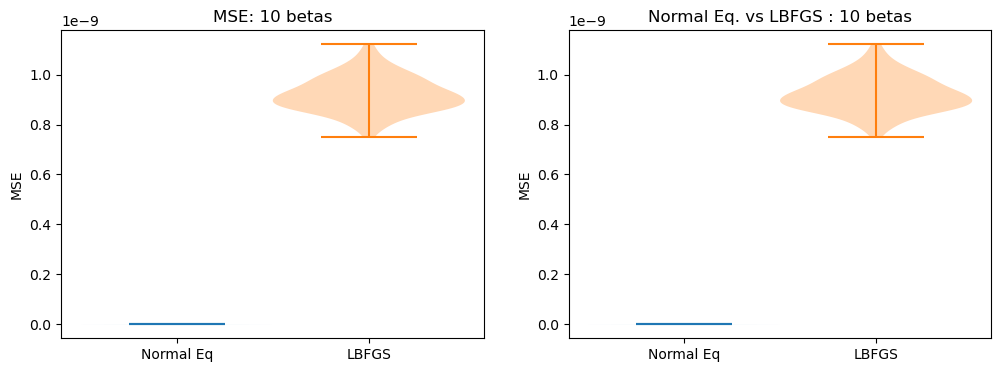

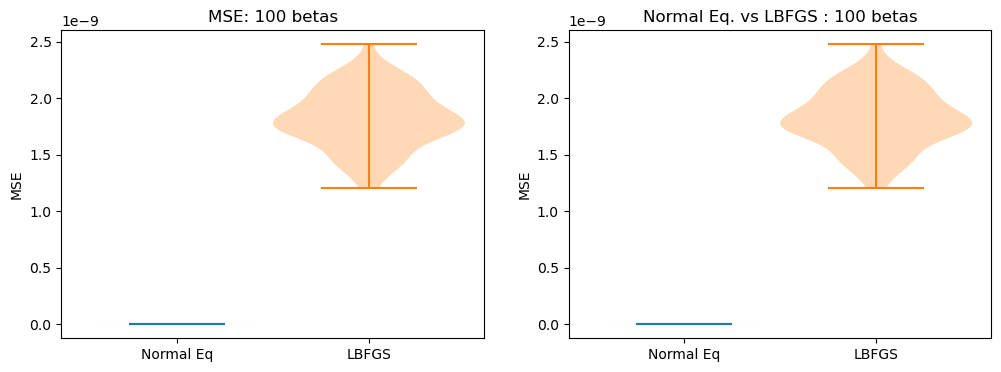

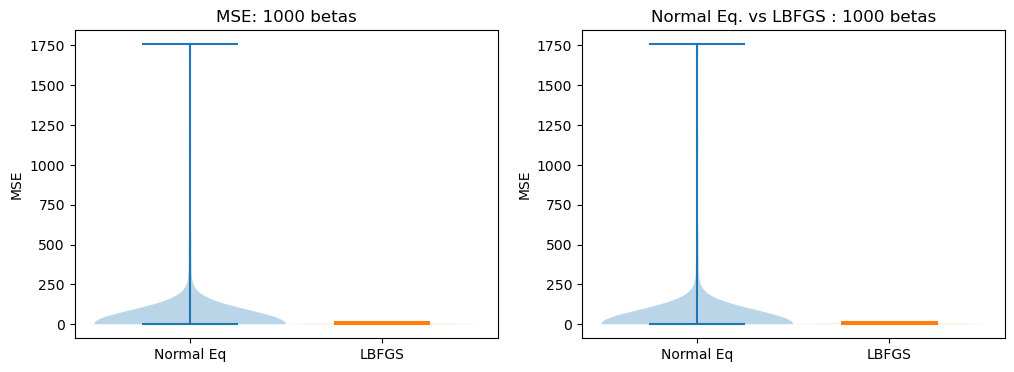

In [274]:
for i in range(4):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    
    axes[0].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[0].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[1.5])
    
    axes[1].violinplot(get_finite_vals(beta_mse['normal'][i]))
    axes[1].violinplot(get_finite_vals(beta_mse['lbfgs'][i]), positions=[1.5])
    
    axes[0].set_xticks([1, 1.5], ['Normal Eq', 'LBFGS'])
    axes[1].set_xticks([1, 1.5], ['Normal Eq', 'LBFGS'])
    
    axes[0].set_title(f'MSE: {ms[i]} betas')
    axes[1].set_title(f'Normal Eq. vs LBFGS : {ms[i]} betas')
    
    axes[0].set_ylabel('MSE')
    axes[1].set_ylabel('MSE')